# 1. Giới thiệu
Trong notebook này, mình sẽ trình bày cách giải quyết đề tài tuyển dụng của VinID. Mô hình CNN được sử dụng để phân loại 10 số viết tay trong bộ MNIST. Trong notebook này,bao gồm các phần sau:

* **1. Giới thiệu**[](http://)
* **2. Tiền xử lý dữ liệu**
    * 2.1 Load dữ liệu
    * 2.2 Kiểm tra missing value
    * 2.3 Chuẩn hóa    
    * 2.5 Label encoding
    * 2.6 Xây dựng tập train/test
* **3. Data augmentation**    
* **4. Xây dựng mô hình**
    * 4.1 Xây dựng mô hình
* **5. Tunning parameter**    
    * 5.1 Khai báo không gian tìm kiếm siêu tham số
    * 5.2 Grid search
* **6. So sánh các optimizer và loss function**    
    * 6.1 So sánh optimizer
    * 6.2 So sánh loss function
* **7. Đánh giá mô hình**
    * 7.1 Confusion matrix
* **8. Dự đoán**
    * 8.1 Predict and Submit results


Cài đặt thư viện hyperas để hỗ trỡ quá trình tunning siêu tham số. Hyperas cung cấp các api rất tiện lợi cho quá trình theo huấn luyện và theo dõi độ chính xác của model tại mỗi bộ tham số. 


In [1]:
!pip install hyperas

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Basic compuational libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import KFold

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, Flatten, GlobalMaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers

# Import hyperopt for tunning hyper params
from hyperopt import hp, tpe, fmin
from hyperopt import space_eval

sns.set(style='white', context='notebook', palette='deep')
# Set the random seed
random_seed = 2

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/framew

# 2. Tiền xử lý
Đọc bộ dữ liệu MNIST, chúng ta chia bộ dữ liệu thành tập train/valid/test. Đồng thời chuẩn hóa dữ liệu về khoảng [0-1] để giúp tăng tốc quá trình hội tụ. Tập valid của chúng ta sẽ gồm 20% tập train. 

In [3]:
def data():
    # Load the data
    train = pd.read_csv("../input/digit-recognizer/train.csv")
    test = pd.read_csv("../input/digit-recognizer/test.csv")
    Y_train = train["label"]
    
    # Drop 'label' column
    X_train = train.drop(labels = ["label"],axis = 1) 
    
    # Normalize the data
    X_train = X_train / 255.0
    test = test / 255.0
    
    # Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
    X_train = X_train.values.reshape(-1,28,28,1)
    test = test.values.reshape(-1,28,28,1)
    
    # Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
    Y_train = to_categorical(Y_train, num_classes = 10)
    
    return X_train, Y_train, test

X, Y, X_test = data()


## Kiểm tra phân bố của nhãn
Chúng ta thấy rằng số lượng mẫu dữ liệu cho mỗi nhãn tương đương nhau. 

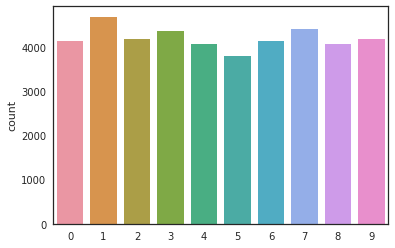

In [4]:
g = sns.countplot(np.argmax(Y, axis=1))

Thử nhìn qua một số mẫu trong tập huấn luyện. Chúng ta thấy rằng hầu hết các ảnh đều rõ nét và tương đối dễ dàng để nhận dạng. 

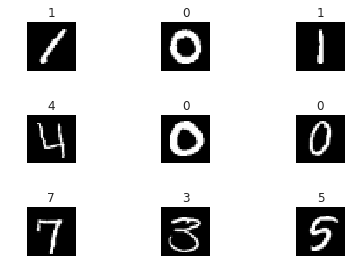

In [5]:
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X[i][:,:,0], cmap=plt.get_cmap('gray'))
    plt.title(np.argmax(Y[i]));
    plt.axis('off')
plt.tight_layout()    

Định nghĩa số epochs cần huấn luyện và bachsize

In [6]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 64

## 3. Data Augmentation
Kĩ thuật data augmentation được sử dụng để phát sinh thêm những mẫu dữ liệu mới bằng cách áp dụng các kĩ thuật xử lý ảnh trên bức ảnh. Các phép biến đổi nhỏ này phải đảm bảo không làm thay đổi nhãn của bức ảnh. 

Một số kĩ thuật phổ biến của data augmentation như là:
* Rotation: Xoay một góc nhỏ
* Translation: Tính tiến
* Brightness, Staturation: Thay đổi độ sáng, tương phản 
* Zoom: zoom to/nhỏ bức ảnh
* Elastic Distortion: biến dạng bức ảnh
* Flip: lật trái/phải/trên/dưới.

Ở dưới đây, chúng ta sẽ chọn xoay 1 góc trong 0-10 độ. Zoom ảnh 0.1 lần, tịnh tiến 0.1 lần mỗi chiều.

In [7]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
train_aug = ImageDataGenerator(        
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        )

test_aug = ImageDataGenerator()


# 4. Xây dưng mô hình CNN
CNN bao gồm tập hợp các lớp cơ bản bao gồm: convolution layer + nonlinear layer, pooling layer, fully connected layer. Các lớp này liên kết với nhau theo một thứ tự nhất định. Thông thường, một ảnh sẽ được lan truyền qua tầng convolution layer + nonlinear layer đầu tiên, sau đó các giá trị tính toán được sẽ lan truyền qua pooling layer, bộ ba convolution layer + nonlinear layer + pooling layer có thể được lặp lại nhiều lần trong network. Và sau đó được lan truyền qua tầng fully connected layer và softmax để tính sác xuất ảnh đó chứa vật thế gì.

![](https://pbcquoc.github.io/images/cnn_model.png)
### Định nghĩa mô hình
Chúng ta sử dụng Keras Sequential API để định nghĩa mô hình. Các layer được thêm vào rất dễ dàng và tương đối linh động. 
Đầu tiên chúng ta sử dụng layer Conv2D trên ảnh đầu vào. Conv2D bao gồm một tập các filters cần phải học. Mỗi filters sẽ trược qua toàn bộ bức ảnh để detect các đặt trưng trên bức ảnh đó. 

Pooling layer là tầng quan trọng và thường đứng sau tầng Conv. Tầng này có chức năng giảm chiều của feature maps trước đó. Đối với max-pooling, tầng này chỉ đơn giản chọn giá trị lớn nhất trong vùng có kích thước pooling_size x pooling_size (thường là 2x2). Tầng pooling này được sử dụng để giảm chi phí tính toán và giảm được overfit của mô hình. 

Đồng thời, Dropout cũng được sử dụng để hạn chế overfit. Dropout sẽ bỏ đi ngẫu nhiên các neuron bằng cách nhân với mask zeros, do đó, giúp mô hình học được những đặc trưng hữu ích. Dropout trong hầu hết các trường hợp đều giúp tăng độ chính xác và hạn chết overfit của mô hình. 

Ở tầng cuối cùng, chúng ta flatten feature matrix thành một vector, sau đó sử dụng các tầng fully connected layers để phân loại ảnh thành các lớp cho trước.

Để giúp mô hình hội tụ gần với gobal minima chúng ta sử dụng annealing learning rate. Learning sẽ được điều chỉnh nhỏ dần sau mỗi lần cập nhật nếu như sau một số bước nhất định mà loss của mô hình không giảm nữa. Để giảm thời gian tính toán, chúng ta có thể sử dụng learning ban đầu lớn, sau đó giảm dần để mô hình hội tụ nhanh hơn.

Ngoài ra, chúng ta sử dụng early stopping để hạn chế hiện tượng overfit của mô hình. early stopping sẽ dừng quá trình huấn luyện nếu như loss trên tập validation tăng dần trong khi trên tập lại giảm. 

### Sử dụng hyperas để tunning siêu tham số
Trong quá trình định nghĩa mô hình, chúng ta sẽ lồng vào đó các đoạn mã để hỗ trợ quá trình search siêu tham số đã được định nghĩa ở trên. Chúng ta sẽ cần search các tham số như filter_size, pooling_size, dropout rate, dense size. Đồng thời chúng ta cũng thử việc điều chỉnh cả optimizer của mô hình.

In [8]:
# Set the CNN model 
def train_model(train_generator, valid_generator, params):    
    model = Sequential()

    model.add(Conv2D(filters = params['conv1'], kernel_size = params['kernel_size_1'], padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = params['conv2'], kernel_size = params['kernel_size_2'], padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size = params['pooling_size_1']))
    model.add(Dropout(params['dropout1']))

    model.add(BatchNormalization())
    model.add(Conv2D(filters = params['conv3'], kernel_size = params['kernel_size_3'], padding = 'Same', 
                     activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = params['conv4'], kernel_size = params['kernel_size_4'], padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size = params['pooling_size_1'], strides=(2,2)))
    model.add(Dropout(params['dropout2']))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(params['dense1'], activation = "relu"))
    model.add(Dropout(params['dropout3']))
    model.add(Dense(10, activation = "softmax"))
    
    if params['opt'] == 'rmsprop':
        opt = RMSprop()
    elif params['opt'] == 'sgd':
        opt = SGD()
    elif params['opt'] == 'nadam':
        opt = Nadam()
    else:
        opt = Adam()
    
    model.compile(loss=params['loss'], optimizer=opt, metrics=['acc'])
        
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, mode='auto', cooldown=2, min_lr=1e-7)
    early = EarlyStopping(monitor='val_loss', patience=3)
    
    callbacks_list = [reduce_lr, early]    
    
    history = model.fit_generator(train_generator,
                                  validation_data=valid_generator,
                                  steps_per_epoch=len(train_generator),
                                  validation_steps=len(valid_generator),
                                  callbacks=callbacks_list, epochs = epochs,
                                  verbose=2)
    
    score, acc = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=0)
    
    return acc, model, history

# 5. Hyper-params tunning
Chúng ta sử dụng Hyperas để tunning các tham số. Hyperas sẽ phát sinh bộ tham số dựa trên khai báo ở trên. Sau đó huấn luyện mô hình và đánh giá trên tập validation. Bộ tham số có độ chính xác cao nhất trên tập validation sẽ được ghi nhận lại. 

## 5.1 Khai báo không gian tìm kiếm siêu tham số
Có rất nhiều siêu tham số cần được tunning như: kiến trúc mạng, số filter, kích thước mỗi filters, kích thước pooling, các cách khởi tạo, hàm kích hoạt, tỉ lệ dropout,... Trong phần này, chúng ta sẽ tập trung vào các tham số  như kích thước filter, số filters, pooling size.

Đầu tiên, chúng ta cần khai báo các siêu tham để hyperas có thể tìm kiếm trong tập đấy. Ở mỗi tầng conv, chúng ta sẽ tunning kích thước filter, filter size. Ở tầng pooling, kích thước pooling size sẽ được tunning. Đồng thời, tỉ lệ dropout ở tầng Dropout cũng được tunning. Số filters ở tầng conv thường từ 16 -> 1024, kích thước filter hay thường dùng nhất trong là 3 với 5. Còn tỉ lệ dropout nằm trong đoạn 0-1

In [9]:
#This is the space of hyperparameters that we will search
space = {
    'opt':hp.choice('opt', ['adam', 'sgd', 'rmsprop']),
    
    'conv1':hp.choice('conv1', [16, 32, 64, 128]),
    'conv2':hp.choice('conv2', [16, 32, 64, 128]),
    'kernel_size_1': hp.choice('kernel_size_1', [3, 5]),
    'kernel_size_2': hp.choice('kernel_size_2', [3, 5]),
    'dropout1': hp.choice('dropout1', [0, 0.25, 0.5]),
    'pooling_size_1': hp.choice('pooling_size_1', [2, 3]),
    
    'conv3':hp.choice('conv3', [32, 64, 128, 256, 512]),
    'conv4':hp.choice('conv4', [32, 64, 128, 256, 512]),
    'kernel_size_3': hp.choice('kernel_size_3', [3, 5]),
    'kernel_size_4': hp.choice('kernel_size_4', [3, 5]),
    'dropout2':hp.choice('dropout2', [0, 0.25, 0.5]),
    'pooling_size_2': hp.choice('pooling_size_2', [2, 3]),
    
    'dense1':hp.choice('dense1', [128, 256, 512, 1024]),
    'dropout3':hp.choice('dropout3', [0, 0.25, 0.5]),
    
    'loss': hp.choice('loss', ['categorical_crossentropy', 'kullback_leibler_divergence']),
}

## 5.2 Optimze để tìm bộ tham số tốt nhất
Hyperas sẽ phát sinh các bộ tham số giữ trên không gian tìm kiếm định nghĩa trước của chúng ta. Sau đó thư viện sẽ hỗ trợ quá trình tìm kiếm các tham số này đơn giản bằng một số API có sẵn. 

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=random_seed)
# only apply data augmentation with train data
train_gen = train_aug.flow(X_train, Y_train, batch_size=batch_size)
valid_gen = test_aug.flow(X_val, Y_val, batch_size=batch_size)

def optimize(params):
    acc, model, history = train_model(train_gen, valid_gen, params)
    
    return -acc

Chạy quá trình search tham số. Bộ siêu tham số tốt nhất sẽ được ghi nhận lại để chúng ta sử dụng trong mô hình cuối cùng. 

In [11]:
best = fmin(fn = optimize, space = space, 
            algo = tpe.suggest, max_evals = 50) # change to 50 to search more

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]


W0914 09:43:05.983868 140240089409280 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0914 09:43:06.065519 140240089409280 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0914 09:43:06.075301 140240089409280 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0914 09:43:06.123427 140240089409280 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0914 09:43

Epoch 1/30                                          
 - 19s - loss: 0.5554 - acc: 0.8958 - val_loss: 0.3073 - val_acc: 0.9707

Epoch 2/30                                          
 - 12s - loss: 0.1966 - acc: 0.9566 - val_loss: 0.1294 - val_acc: 0.9815

Epoch 3/30                                          
 - 13s - loss: 0.1257 - acc: 0.9689 - val_loss: 0.1337 - val_acc: 0.9817

Epoch 4/30                                          
 - 12s - loss: 0.1069 - acc: 0.9740 - val_loss: 0.0717 - val_acc: 0.9871

Epoch 5/30                                          
 - 13s - loss: 0.1014 - acc: 0.9768 - val_loss: 0.0616 - val_acc: 0.9875

Epoch 6/30                                          
 - 12s - loss: 0.0942 - acc: 0.9792 - val_loss: 0.0549 - val_acc: 0.9881

Epoch 7/30                                          
 - 13s - loss: 0.0926 - acc: 0.9790 - val_loss: 0.0696 - val_acc: 0.9896

Epoch 8/30                                          
 - 13s - loss: 0.0939 - acc: 0.9791 - val_loss: 0.0530 - v

Epoch 6/30                                                                       
 - 13s - loss: 0.0870 - acc: 0.9771 - val_loss: 0.0348 - val_acc: 0.9919         

Epoch 7/30                                                                       
 - 13s - loss: 0.0813 - acc: 0.9798 - val_loss: 0.0335 - val_acc: 0.9927         

Epoch 8/30                                                                       
 - 13s - loss: 0.0744 - acc: 0.9815 - val_loss: 0.0335 - val_acc: 0.9923         

Epoch 9/30                                                                       
 - 13s - loss: 0.0745 - acc: 0.9807 - val_loss: 0.0292 - val_acc: 0.9930         

Epoch 10/30                                                                      
 - 13s - loss: 0.0695 - acc: 0.9824 - val_loss: 0.0333 - val_acc: 0.9920         

Epoch 11/30                                                                      
 - 13s - loss: 0.0708 - acc: 0.9822 - val_loss: 0.0388 - val_acc: 0.9919         

Epoch 12/3

 - 13s - loss: 0.0549 - acc: 0.9827 - val_loss: 0.0229 - val_acc: 0.9923         

Epoch 18/30                                                                      
 - 13s - loss: 0.0588 - acc: 0.9823 - val_loss: 0.0220 - val_acc: 0.9924         

Epoch 19/30                                                                      
 - 14s - loss: 0.0565 - acc: 0.9834 - val_loss: 0.0212 - val_acc: 0.9932         

Epoch 20/30                                                                      
 - 13s - loss: 0.0563 - acc: 0.9834 - val_loss: 0.0254 - val_acc: 0.9917         

Epoch 21/30                                                                      
 - 13s - loss: 0.0544 - acc: 0.9833 - val_loss: 0.0199 - val_acc: 0.9939         

Epoch 22/30                                                                      
 - 13s - loss: 0.0542 - acc: 0.9838 - val_loss: 0.0233 - val_acc: 0.9921         

Epoch 23/30                                                                      
 - 13s - l

Epoch 17/30                                                                      
 - 13s - loss: 0.0316 - acc: 0.9904 - val_loss: 0.0167 - val_acc: 0.9950         

Epoch 18/30                                                                      
 - 13s - loss: 0.0334 - acc: 0.9894 - val_loss: 0.0177 - val_acc: 0.9946         

Epoch 19/30                                                                      
 - 13s - loss: 0.0315 - acc: 0.9901 - val_loss: 0.0156 - val_acc: 0.9956         

Epoch 20/30                                                                      
 - 13s - loss: 0.0322 - acc: 0.9901 - val_loss: 0.0156 - val_acc: 0.9955         

Epoch 21/30                                                                      
 - 14s - loss: 0.0317 - acc: 0.9900 - val_loss: 0.0161 - val_acc: 0.9951         

Epoch 22/30                                                                      
 - 13s - loss: 0.0296 - acc: 0.9907 - val_loss: 0.0158 - val_acc: 0.9952         

Epoch 1/30

Epoch 6/30                                                           
 - 14s - loss: 0.0968 - acc: 0.9724 - val_loss: 0.0390 - val_acc: 0.9882

Epoch 7/30                                                           
 - 14s - loss: 0.0925 - acc: 0.9725 - val_loss: 0.0324 - val_acc: 0.9894

Epoch 8/30                                                           
 - 13s - loss: 0.0977 - acc: 0.9727 - val_loss: 0.0340 - val_acc: 0.9888

Epoch 9/30                                                           
 - 14s - loss: 0.0794 - acc: 0.9767 - val_loss: 0.0294 - val_acc: 0.9911

Epoch 10/30                                                          
 - 14s - loss: 0.0838 - acc: 0.9761 - val_loss: 0.0540 - val_acc: 0.9869

Epoch 11/30                                                          
 - 13s - loss: 0.0861 - acc: 0.9764 - val_loss: 0.0399 - val_acc: 0.9877

Epoch 12/30                                                          
 - 14s - loss: 0.0607 - acc: 0.9826 - val_loss: 0.0260 - val_acc: 

 - 15s - loss: 0.0820 - acc: 0.9738 - val_loss: 0.0434 - val_acc: 0.9875            

Epoch 4/30                                                                          
 - 15s - loss: 0.0646 - acc: 0.9794 - val_loss: 0.0297 - val_acc: 0.9911            

Epoch 5/30                                                                          
 - 15s - loss: 0.0583 - acc: 0.9808 - val_loss: 0.0317 - val_acc: 0.9895            

Epoch 6/30                                                                          
 - 15s - loss: 0.0523 - acc: 0.9835 - val_loss: 0.0316 - val_acc: 0.9892            

Epoch 7/30                                                                          
 - 15s - loss: 0.0454 - acc: 0.9856 - val_loss: 0.0255 - val_acc: 0.9915            

Epoch 8/30                                                                          
 - 15s - loss: 0.0411 - acc: 0.9875 - val_loss: 0.0258 - val_acc: 0.9923            

Epoch 9/30                                                 

Epoch 17/30                                                                         
 - 14s - loss: 0.0323 - acc: 0.9934 - val_loss: 0.0360 - val_acc: 0.9964            

Epoch 18/30                                                                         
 - 14s - loss: 0.0322 - acc: 0.9933 - val_loss: 0.0428 - val_acc: 0.9956            

Epoch 19/30                                                                         
 - 14s - loss: 0.0341 - acc: 0.9940 - val_loss: 0.0427 - val_acc: 0.9951            

Epoch 20/30                                                                         
 - 14s - loss: 0.0329 - acc: 0.9933 - val_loss: 0.0440 - val_acc: 0.9950            

Epoch 1/30                                                                          
 - 23s - loss: 0.7654 - acc: 0.7562 - val_loss: 0.1295 - val_acc: 0.9629            

Epoch 2/30                                                                          
 - 14s - loss: 0.2781 - acc: 0.9148 - val_loss: 0.0799 - val

 - 15s - loss: 0.1175 - acc: 0.9656 - val_loss: 0.0693 - val_acc: 0.9798            

Epoch 5/30                                                                          
 - 14s - loss: 0.1004 - acc: 0.9695 - val_loss: 0.0393 - val_acc: 0.9877            

Epoch 6/30                                                                          
 - 14s - loss: 0.0913 - acc: 0.9726 - val_loss: 0.0270 - val_acc: 0.9929            

Epoch 7/30                                                                          
 - 15s - loss: 0.0869 - acc: 0.9737 - val_loss: 0.0312 - val_acc: 0.9901            

Epoch 8/30                                                                          
 - 14s - loss: 0.0786 - acc: 0.9759 - val_loss: 0.0509 - val_acc: 0.9844            

Epoch 9/30                                                                          
 - 14s - loss: 0.0578 - acc: 0.9821 - val_loss: 0.0218 - val_acc: 0.9937            

Epoch 10/30                                                

Epoch 3/30                                                                          
 - 15s - loss: 0.0717 - acc: 0.9766 - val_loss: 0.0340 - val_acc: 0.9894            

Epoch 4/30                                                                          
 - 15s - loss: 0.0644 - acc: 0.9796 - val_loss: 0.0295 - val_acc: 0.9912            

Epoch 5/30                                                                          
 - 15s - loss: 0.0508 - acc: 0.9833 - val_loss: 0.0249 - val_acc: 0.9921            

Epoch 6/30                                                                          
 - 14s - loss: 0.0523 - acc: 0.9834 - val_loss: 0.0188 - val_acc: 0.9937            

Epoch 7/30                                                                          
 - 14s - loss: 0.0470 - acc: 0.9853 - val_loss: 0.0235 - val_acc: 0.9929            

Epoch 8/30                                                                          
 - 14s - loss: 0.0413 - acc: 0.9866 - val_loss: 0.0316 - val

 - 14s - loss: 0.0720 - acc: 0.9781 - val_loss: 0.0278 - val_acc: 0.9902            

Epoch 4/30                                                                          
 - 14s - loss: 0.0647 - acc: 0.9785 - val_loss: 0.0295 - val_acc: 0.9920            

Epoch 5/30                                                                          
 - 15s - loss: 0.0559 - acc: 0.9820 - val_loss: 0.0308 - val_acc: 0.9904            

Epoch 6/30                                                                          
 - 15s - loss: 0.0500 - acc: 0.9844 - val_loss: 0.0211 - val_acc: 0.9937            

Epoch 7/30                                                                          
 - 15s - loss: 0.0453 - acc: 0.9854 - val_loss: 0.0219 - val_acc: 0.9933            

Epoch 8/30                                                                          
 - 15s - loss: 0.0433 - acc: 0.9857 - val_loss: 0.0225 - val_acc: 0.9935            

Epoch 9/30                                                 

Epoch 9/30                                                                          
 - 15s - loss: 0.0383 - acc: 0.9876 - val_loss: 0.0219 - val_acc: 0.9930            

Epoch 1/30                                                                          
 - 29s - loss: 0.5410 - acc: 0.8257 - val_loss: 0.0846 - val_acc: 0.9732            

Epoch 2/30                                                                          
 - 15s - loss: 0.1835 - acc: 0.9438 - val_loss: 0.0549 - val_acc: 0.9832            

Epoch 3/30                                                                          
 - 15s - loss: 0.1286 - acc: 0.9605 - val_loss: 0.0496 - val_acc: 0.9850            

Epoch 4/30                                                                          
 - 15s - loss: 0.1089 - acc: 0.9670 - val_loss: 0.0376 - val_acc: 0.9880            

Epoch 5/30                                                                          
 - 15s - loss: 0.0955 - acc: 0.9707 - val_loss: 0.0380 - val

 - 16s - loss: 0.0150 - acc: 0.9957 - val_loss: 0.0169 - val_acc: 0.9949            

Epoch 20/30                                                                         
 - 15s - loss: 0.0153 - acc: 0.9959 - val_loss: 0.0166 - val_acc: 0.9951            

Epoch 21/30                                                                         
 - 15s - loss: 0.0148 - acc: 0.9956 - val_loss: 0.0165 - val_acc: 0.9950            

Epoch 1/30                                                                          
 - 30s - loss: 0.4987 - acc: 0.8427 - val_loss: 0.1087 - val_acc: 0.9671            

Epoch 2/30                                                                          
 - 15s - loss: 0.1680 - acc: 0.9492 - val_loss: 0.0691 - val_acc: 0.9795            

Epoch 3/30                                                                          
 - 15s - loss: 0.1223 - acc: 0.9624 - val_loss: 0.0353 - val_acc: 0.9888            

Epoch 4/30                                                 

 - 16s - loss: 0.0691 - acc: 0.9865 - val_loss: 0.0395 - val_acc: 0.9942          

Epoch 11/30                                                                       
 - 16s - loss: 0.0565 - acc: 0.9891 - val_loss: 0.0358 - val_acc: 0.9951          

Epoch 12/30                                                                       
 - 16s - loss: 0.0511 - acc: 0.9895 - val_loss: 0.0427 - val_acc: 0.9945          

Epoch 13/30                                                                       
 - 16s - loss: 0.0561 - acc: 0.9897 - val_loss: 0.0484 - val_acc: 0.9937          

Epoch 14/30                                                                       
 - 16s - loss: 0.0473 - acc: 0.9910 - val_loss: 0.0385 - val_acc: 0.9950          

Epoch 1/30                                                                        
 - 43s - loss: 0.2885 - acc: 0.9180 - val_loss: 0.0806 - val_acc: 0.9770          

Epoch 2/30                                                                       

Epoch 1/30                                                                          
 - 34s - loss: 0.3253 - acc: 0.9127 - val_loss: 0.1139 - val_acc: 0.9807            

Epoch 2/30                                                                          
 - 16s - loss: 0.1609 - acc: 0.9636 - val_loss: 0.1716 - val_acc: 0.9705            

Epoch 3/30                                                                          
 - 16s - loss: 0.1301 - acc: 0.9702 - val_loss: 0.1231 - val_acc: 0.9846            

Epoch 4/30                                                                          
 - 16s - loss: 0.0756 - acc: 0.9826 - val_loss: 0.0505 - val_acc: 0.9926            

Epoch 5/30                                                                          
 - 16s - loss: 0.0640 - acc: 0.9851 - val_loss: 0.0426 - val_acc: 0.9929            

Epoch 6/30                                                                          
 - 16s - loss: 0.0590 - acc: 0.9860 - val_loss: 0.0519 - val

 - 16s - loss: 0.0716 - acc: 0.9798 - val_loss: 0.0752 - val_acc: 0.9838          

Epoch 4/30                                                                        
 - 16s - loss: 0.0651 - acc: 0.9826 - val_loss: 0.0730 - val_acc: 0.9824          

Epoch 5/30                                                                        
 - 16s - loss: 0.0517 - acc: 0.9859 - val_loss: 0.0763 - val_acc: 0.9854          

Epoch 6/30                                                                        
 - 16s - loss: 0.0506 - acc: 0.9851 - val_loss: 0.0316 - val_acc: 0.9921          

Epoch 7/30                                                                        
 - 16s - loss: 0.0440 - acc: 0.9865 - val_loss: 0.0342 - val_acc: 0.9931          

Epoch 8/30                                                                        
 - 16s - loss: 0.0436 - acc: 0.9879 - val_loss: 0.0499 - val_acc: 0.9898          

Epoch 9/30                                                                       

 - 16s - loss: 0.0477 - acc: 0.9861 - val_loss: 0.0421 - val_acc: 0.9889          

Epoch 9/30                                                                        
 - 17s - loss: 0.0280 - acc: 0.9916 - val_loss: 0.0231 - val_acc: 0.9944          

Epoch 10/30                                                                       
 - 16s - loss: 0.0217 - acc: 0.9936 - val_loss: 0.0180 - val_acc: 0.9942          

Epoch 11/30                                                                       
 - 16s - loss: 0.0215 - acc: 0.9934 - val_loss: 0.0267 - val_acc: 0.9932          

Epoch 12/30                                                                       
 - 16s - loss: 0.0185 - acc: 0.9938 - val_loss: 0.0175 - val_acc: 0.9946          

Epoch 13/30                                                                       
 - 16s - loss: 0.0199 - acc: 0.9943 - val_loss: 0.0219 - val_acc: 0.9937          

Epoch 14/30                                                                      

 - 16s - loss: 0.0268 - acc: 0.9916 - val_loss: 0.0160 - val_acc: 0.9949          

Epoch 15/30                                                                       
 - 16s - loss: 0.0264 - acc: 0.9919 - val_loss: 0.0179 - val_acc: 0.9950          

Epoch 16/30                                                                       
 - 16s - loss: 0.0229 - acc: 0.9923 - val_loss: 0.0178 - val_acc: 0.9937          

Epoch 17/30                                                                       
 - 17s - loss: 0.0245 - acc: 0.9929 - val_loss: 0.0151 - val_acc: 0.9952          

Epoch 18/30                                                                       
 - 17s - loss: 0.0237 - acc: 0.9921 - val_loss: 0.0146 - val_acc: 0.9948          

Epoch 19/30                                                                       
 - 17s - loss: 0.0245 - acc: 0.9922 - val_loss: 0.0157 - val_acc: 0.9951          

Epoch 20/30                                                                      

 - 17s - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0156 - val_acc: 0.9952          

Epoch 21/30                                                                       
 - 16s - loss: 0.0064 - acc: 0.9980 - val_loss: 0.0139 - val_acc: 0.9960          

Epoch 22/30                                                                       
 - 17s - loss: 0.0058 - acc: 0.9982 - val_loss: 0.0135 - val_acc: 0.9955          

Epoch 23/30                                                                       
 - 18s - loss: 0.0050 - acc: 0.9987 - val_loss: 0.0144 - val_acc: 0.9954          

Epoch 24/30                                                                       
 - 18s - loss: 0.0054 - acc: 0.9984 - val_loss: 0.0162 - val_acc: 0.9951          

Epoch 25/30                                                                       
 - 17s - loss: 0.0055 - acc: 0.9984 - val_loss: 0.0135 - val_acc: 0.9962          

100%|██████████| 50/50 [3:55:42<00:00, 378.77s/it, best loss: -0.9966666666666667

In [12]:
best_params = space_eval(space, best)
print('best hyper params: \n', best_params)

best hyper params: 
 {'conv1': 128, 'conv2': 128, 'conv3': 32, 'conv4': 32, 'dense1': 512, 'dropout1': 0, 'dropout2': 0, 'dropout3': 0, 'kernel_size_1': 5, 'kernel_size_2': 3, 'kernel_size_3': 3, 'kernel_size_4': 5, 'loss': 'kullback_leibler_divergence', 'opt': 'adam', 'pooling_size_1': 3, 'pooling_size_2': 2}


Huấn luyện lại mô hình với bộ tham số tốt nhất ở trên.

In [13]:
acc, model, history = train_model(train_gen, valid_gen, best_params)
print("validation accuracy: {}".format(acc))

Epoch 1/30
 - 43s - loss: 0.1557 - acc: 0.9516 - val_loss: 0.0764 - val_acc: 0.9782
Epoch 2/30
 - 17s - loss: 0.0708 - acc: 0.9782 - val_loss: 0.0628 - val_acc: 0.9832
Epoch 3/30
 - 17s - loss: 0.0596 - acc: 0.9826 - val_loss: 0.0463 - val_acc: 0.9870
Epoch 4/30
 - 17s - loss: 0.0505 - acc: 0.9849 - val_loss: 0.0571 - val_acc: 0.9842
Epoch 5/30
 - 17s - loss: 0.0459 - acc: 0.9856 - val_loss: 0.0496 - val_acc: 0.9873
Epoch 6/30
 - 17s - loss: 0.0247 - acc: 0.9927 - val_loss: 0.0215 - val_acc: 0.9943
Epoch 7/30
 - 17s - loss: 0.0196 - acc: 0.9938 - val_loss: 0.0195 - val_acc: 0.9942
Epoch 8/30
 - 17s - loss: 0.0161 - acc: 0.9953 - val_loss: 0.0248 - val_acc: 0.9943
Epoch 9/30
 - 17s - loss: 0.0170 - acc: 0.9946 - val_loss: 0.0221 - val_acc: 0.9946
Epoch 10/30
 - 17s - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0168 - val_acc: 0.9958
Epoch 11/30
 - 17s - loss: 0.0115 - acc: 0.9970 - val_loss: 0.0195 - val_acc: 0.9951
Epoch 12/30
 - 17s - loss: 0.0109 - acc: 0.9966 - val_loss: 0.0165 - val_a

Kết quả trên tập validation khá cao với acc > 99%

# 6. So sánh optimizers và loss
## 6.1 So sánh các optimzers

Mục tiêu của quá trình huấn luyện mô hình ML là giảm độ lỗi của hàm loss function được tính bằng sự khác biệt của giá trị mô hình dự đoán và giá trị thực tế. Để đạt được mục đích này chúng ta thường sử dụng gradient descent. Gradient descent sẽ cập nhật trọng số của mô hình ngược với chiều gradient để giảm độ lỗi của loss function. 
![image.png](https://miro.medium.com/max/414/1*6a9Gx2UlB1ksh92TabyGPQ.png)

Chúng ta sử thường sử dụng 3 optimzer phổ biến sau là adam, sgd, rmsprop để cập nhật trọng số của mô hình. 
Stochastic Gradient Descent là một biến thể của Gradient Descent, yêu cầu chúng ta phải shuffle dự liệu trước khi huấn luyện. Trong khi đó RMSProp và Adam là 2 optimizer hướng đến việc điều chỉnh learning rate tự động theo quá trình học.

RMSprop (Root mean square propagation) được giới thiệu bởi Geoffrey Hinton. RMSProp giải quyết vấn đề giảm dần learning rate của Adagrad bằng cách chuẩn hóa learning với gradient gần với thời điểm cập nhật mà thôi. Để làm được điều này tác giả chia learning rate cho tổng bình phương gradient giảm dần. 
![](https://miro.medium.com/max/786/1*adEDAdjulZUJisfzurVuWw.png)

Adam là optimizer phổ biến nhất tại thời điểm hiện tại. Adam cũng tính learning riêng biệt cho từng tham số, tương tự như RMSProp và Adagrad. Adam chuẩn hóa learning của mỗi tham số bằng first và second order moment của gradient. 

In [14]:
optimizers = ['rmsprop', 'sgd', 'adam']
hists = []
params = best_params
for optimizer in optimizers:
    params['opt'] = optimizer
    print("Train with optimizer: {}".format(optimizer))
    _, _, history = train_model(train_gen, valid_gen, params)
    hists.append((optimizer, history))

Train with optimizer: rmsprop
Epoch 1/30
 - 42s - loss: 0.1667 - acc: 0.9488 - val_loss: 0.1342 - val_acc: 0.9690
Epoch 2/30
 - 17s - loss: 0.0814 - acc: 0.9774 - val_loss: 0.0725 - val_acc: 0.9790
Epoch 3/30
 - 17s - loss: 0.0648 - acc: 0.9825 - val_loss: 0.0563 - val_acc: 0.9851
Epoch 4/30
 - 17s - loss: 0.0563 - acc: 0.9844 - val_loss: 0.0644 - val_acc: 0.9887
Epoch 5/30
 - 16s - loss: 0.0484 - acc: 0.9871 - val_loss: 0.0777 - val_acc: 0.9849
Epoch 6/30
 - 18s - loss: 0.0305 - acc: 0.9923 - val_loss: 0.0277 - val_acc: 0.9951
Epoch 7/30
 - 18s - loss: 0.0225 - acc: 0.9941 - val_loss: 0.0271 - val_acc: 0.9939
Epoch 8/30
 - 17s - loss: 0.0184 - acc: 0.9947 - val_loss: 0.0242 - val_acc: 0.9958
Epoch 9/30
 - 17s - loss: 0.0200 - acc: 0.9948 - val_loss: 0.0264 - val_acc: 0.9951
Epoch 10/30
 - 17s - loss: 0.0158 - acc: 0.9956 - val_loss: 0.0263 - val_acc: 0.9955
Epoch 11/30
 - 17s - loss: 0.0149 - acc: 0.9960 - val_loss: 0.0279 - val_acc: 0.9943
Train with optimizer: sgd
Epoch 1/30
 - 42s 

Plot quá trình huấn luyện mô hình với 3 lọai optimizers khác nhau.

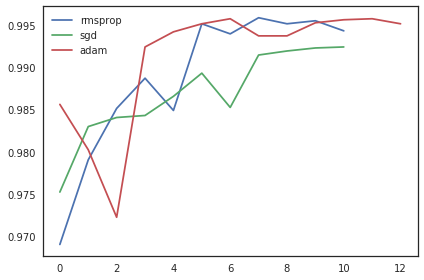

In [15]:
for name, history in hists:
    plt.plot(history.history['val_acc'], label=name)

plt.legend(loc='best', shadow=True)
plt.tight_layout()

## 6.2 So sánh các loss function 
Trong bài toán phân loại nhiều lớp. Chúng ta thường sử dụng 2 loại loss function sau:
* Cross entropy
* Kullback Leibler Divergence Loss

Cross entropy được sử dụng phổ biến nhất trong bài toán của chúng ta. Cross entropy loss có nền tảng toán học của maximun likelihood được tính bằng tổng của sự khác biệt giữ giá trị dự đoán và giá trị thực tế của dữ liệu. Cross entropy error tốt nhất khi có giá trị bằng 0.

KL loss (Kullback Leibler Divergence Loss) thể hiện sự khác biệt giữ 2 phân bố xác suất. KL loss bằng 0, chứng tỏ 2 phân bố này hoàn toàn giống nhau. 

Cross entropy cho bằng toán phân loại nhiều lớn tương đối giống với KL Loss về mặt toán học, nên có thể xem 2 độ lỗi này là một trong bài toán của chúng ta. 

In [16]:
loss_functions = ['categorical_crossentropy', 'kullback_leibler_divergence']
hists = []
params = best_params
for loss_funct in loss_functions:
    params['loss'] = loss_funct
    print("Train with loss function : {}".format(loss_funct))
    _, _, history = train_model(train_gen, valid_gen, params)
    hists.append((loss_funct, history))

Train with loss function : categorical_crossentropy
Epoch 1/30
 - 44s - loss: 0.1543 - acc: 0.9505 - val_loss: 0.0602 - val_acc: 0.9825
Epoch 2/30
 - 17s - loss: 0.0734 - acc: 0.9780 - val_loss: 0.0768 - val_acc: 0.9806
Epoch 3/30
 - 18s - loss: 0.0606 - acc: 0.9826 - val_loss: 0.0422 - val_acc: 0.9885
Epoch 4/30
 - 17s - loss: 0.0506 - acc: 0.9845 - val_loss: 0.0298 - val_acc: 0.9913
Epoch 5/30
 - 18s - loss: 0.0460 - acc: 0.9861 - val_loss: 0.0365 - val_acc: 0.9915
Epoch 6/30
 - 17s - loss: 0.0401 - acc: 0.9883 - val_loss: 0.0471 - val_acc: 0.9885
Epoch 7/30
 - 17s - loss: 0.0239 - acc: 0.9929 - val_loss: 0.0205 - val_acc: 0.9946
Epoch 8/30
 - 18s - loss: 0.0187 - acc: 0.9948 - val_loss: 0.0222 - val_acc: 0.9950
Epoch 9/30
 - 17s - loss: 0.0161 - acc: 0.9948 - val_loss: 0.0215 - val_acc: 0.9939
Epoch 10/30
 - 17s - loss: 0.0136 - acc: 0.9957 - val_loss: 0.0159 - val_acc: 0.9954
Epoch 11/30
 - 18s - loss: 0.0119 - acc: 0.9965 - val_loss: 0.0163 - val_acc: 0.9950
Epoch 12/30
 - 18s - l

Plot quá trình huấn luyện mô hình với 2 loại loss function khác nhau.

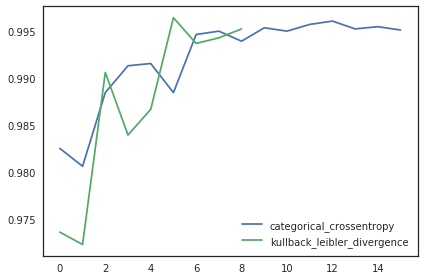

In [17]:
for name, history in hists:
    plt.plot(history.history['val_acc'], label=name)

plt.legend(loc='best', shadow=True)
plt.tight_layout()


Chúng ta thấy rằng không có sự khác biệt rõ rằng về tốc độ hội tụ giữ 2 hàm loss function là cross-entropy và KL loss trong bài toán của chúng ta.

# 7. Đánh giá mô hình. 
Chúng ta sẽ xem xét một số lỗi của mô hình dự huấn luyện được. Một số lỗi dễ dàng được phát hiện bằng confusion matrix thể hiện xác xuất/số ảnh bị phân loại nhầm thành lớp khác.

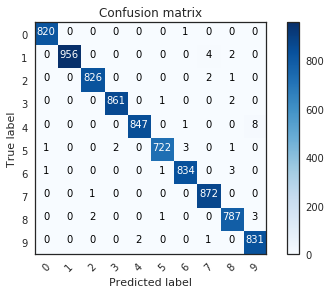

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Các giá trị trên đường chéo rất cao, chúng ta mô hình chúng ta có độ chính xác rất tốt.
Nhìn vào confusion matrix ở trên, chúng ta có một số nhận xét như sau:
* Số 4 hay nhầm lẫn với số 9, bởi vì khi viết tay đường nét của 2 số này tương tự nhau khá nhiều
* số 3 và số 8, cũng hay bị tình trạng tương tự. 

## Hiển thị một số trường hợp bị sai
Để có cái nhìn rõ hơn về một số mẫu bị sai, chúng ta quan sát top các mẫu có giá trị dự đoán khác nhất so với nhãn thật 

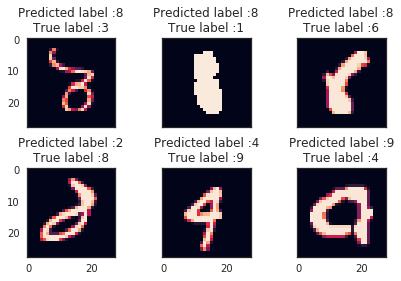

In [19]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    fig.tight_layout()
    
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Với các mẫu ảnh sai, chúng ta có thể thấy rằng những mẫu này rất khó nhận dạng nhầm lẫn sáng các lớp khác. ví dụ số 9 và 4 hay là 3 và 8

## 8. Kfold, Predict và submit kết quả
Chúng ta huấn luyện lại mô hình sử dụng kfold, kết quả cuối dự đoán cuối cùng là trung bình cộng sự đoán của các mô hình huấn luyện trên mỗi fold.
Chúng ta chọn nhãn là lớp được dự đoán có xác suất cao nhất mà mô hình nhận dạng được

In [20]:
kf = KFold(n_splits=5)
preds = []
for train_index, valid_index in kf.split(X):
    X_train, Y_train, X_val, Y_val = X[train_index], Y[train_index], X[valid_index], Y[valid_index]
    train_gen = train_aug.flow(X_train, Y_train, batch_size=batch_size)
    valid_gen = test_aug.flow(X_val, Y_val, batch_size=batch_size)
    acc, model, history = train_model(train_gen, valid_gen, best_params)
    
    pred = model.predict(X_test)
    preds.append(pred)

Epoch 1/30
 - 41s - loss: 0.1605 - acc: 0.9510 - val_loss: 0.1090 - val_acc: 0.9704
Epoch 2/30
 - 18s - loss: 0.0744 - acc: 0.9780 - val_loss: 0.0754 - val_acc: 0.9787
Epoch 3/30
 - 17s - loss: 0.0538 - acc: 0.9839 - val_loss: 0.0673 - val_acc: 0.9818
Epoch 4/30
 - 17s - loss: 0.0577 - acc: 0.9837 - val_loss: 0.0437 - val_acc: 0.9864
Epoch 5/30
 - 17s - loss: 0.0434 - acc: 0.9868 - val_loss: 0.0358 - val_acc: 0.9901
Epoch 6/30
 - 17s - loss: 0.0433 - acc: 0.9873 - val_loss: 0.0448 - val_acc: 0.9877
Epoch 7/30
 - 16s - loss: 0.0363 - acc: 0.9893 - val_loss: 0.0391 - val_acc: 0.9907
Epoch 8/30
 - 17s - loss: 0.0214 - acc: 0.9934 - val_loss: 0.0252 - val_acc: 0.9926
Epoch 9/30
 - 17s - loss: 0.0169 - acc: 0.9946 - val_loss: 0.0249 - val_acc: 0.9927
Epoch 10/30
 - 18s - loss: 0.0145 - acc: 0.9957 - val_loss: 0.0328 - val_acc: 0.9907
Epoch 11/30
 - 17s - loss: 0.0152 - acc: 0.9951 - val_loss: 0.0212 - val_acc: 0.9935
Epoch 12/30
 - 18s - loss: 0.0160 - acc: 0.9950 - val_loss: 0.0283 - val_a

In [21]:
# predict results
results = np.mean(preds, axis=0)
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [22]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

Lúc chạy thực tế, cần thay max_evals lúc search tham số thành 50 để có được accuracy trên tập test > 0.997. Kết quả dưới đây được submit trên kaggle mà không sử dụng kfold 
![](https://github.com/pbcquoc/pbcquoc.github.io/raw/master/images/kaggle.png)